In [1]:
import os
print(os.getcwd())

/Users/user/Desktop


In [2]:
# os.chdir(r'C:/Users/user/Desktop/Hevrin Data') # r is a raw string, not read as an escape sequence
print(os.getcwd())  # so copied and pasted the required files from IDrive located by a search

/Users/user/Desktop


# I. DATA WRANGLING TO OBTAIN A TIME SERIES WITH A DATETIME INDEX

In [3]:
import pandas as pd
df= pd.read_csv('Hevrin Usage.csv',header= None,skiprows= 17, usecols= [*range(45,70)]) 
# skip rows st start August 1st
# nrows= 730,   nrows st two years to start with: better is all days, then resample to weekly with .resample('W')
print(df.shape)
df.head()

(2788, 25)


,45,46,47,48,49,50,51,52,53,54,...,60,61,62,63,64,65,66,67,68,69
0,08/01/2011,0.77,0.64,0.70,0.58,0.58,0.51,0.70,0.70,0.32,...,1.600,2.18,2.50,2.75,3.58,3.33,3.33,3.33,2.62,1.60
1,08/02/2011,0.77,0.64,0.70,0.70,0.58,0.64,0.70,0.38,0.26,...,2.112,1.66,2.43,3.07,4.29,8.45,6.08,3.71,2.75,1.86
2,08/03/2011,1.22,0.70,0.77,0.70,1.09,0.77,0.83,0.38,0.32,...,1.536,2.43,3.20,3.26,2.69,3.97,3.26,3.46,1.47,0.45
3,08/04/2011,0.38,0.58,0.38,0.38,0.38,0.32,0.45,0.38,0.32,...,0.704,2.05,3.39,3.65,3.33,2.56,1.47,1.09,1.22,0.77
4,08/05/2011,0.51,0.70,0.45,0.38,0.51,0.38,0.51,0.32,0.32,...,1.088,1.86,2.75,3.20,2.50,1.92,1.54,1.22,1.22,0.77


In [4]:
# df.info()

In [5]:
df.columns= ['day','00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23']

In [6]:
df= df.set_index(df['day'])
df= df.drop(['day'], axis=1)
df.tail(3)

,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
03/17/2019,0.58,0.45,0.58,0.58,0.45,0.51,0.51,0.51,0.96,2.11,...,1.024,0.96,0.96,1.22,2.18,6.78,2.75,2.88,0.83,0.51
03/18/2019,0.45,0.51,0.51,0.51,0.51,0.51,0.58,3.97,3.33,0.70,...,4.352,6.78,2.56,0.96,0.45,0.77,0.90,0.83,2.82,0.58
03/19/2019,0.58,0.51,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
dft= df.stack()
dft=dft.reset_index()
dft.columns= ['day','hour','kwh'] # where 'day' is string, not DT

In [8]:
dft.head(8)

,day,hour,kwh
0,08/01/2011,00,0.77
1,08/01/2011,01,0.64
2,08/01/2011,02,0.70
3,08/01/2011,03,0.58
4,08/01/2011,04,0.58
5,08/01/2011,05,0.51
6,08/01/2011,06,0.70
7,08/01/2011,07,0.70


In [9]:
dft['date']= pd.to_datetime(dft['day'] + ' ' + dft['hour'] + ':00:00')
from datetime import datetime
dft['weekday']= dft.date.dt.weekday_name
dft['month']= dft.date.dt.month
dft['year']= dft.date.dt.year
dft.set_index(dft['date'], inplace= True)
dft= dft.drop(['day','date'], axis=1)
dft['hour']= dft['hour'].astype('category')
dft['weekday']= dft['weekday'].astype('category')
dft['month']= dft['month'].astype('category')
dft['year']= dft['year'].astype('category')
dft.info()
dft.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66505 entries, 2011-08-01 00:00:00 to 2019-03-19 02:00:00
Data columns (total 5 columns):
hour       66505 non-null category
kwh        66505 non-null float64
weekday    66505 non-null category
month      66505 non-null category
year       66505 non-null category
dtypes: category(4), float64(1)
memory usage: 1.3 MB


,hour,kwh,weekday,month,year
date,,,,,
2011-08-01 00:00:00,00,0.77,Monday,8,2011
2011-08-01 01:00:00,01,0.64,Monday,8,2011
2011-08-01 02:00:00,02,0.70,Monday,8,2011
2011-08-01 03:00:00,03,0.58,Monday,8,2011
2011-08-01 04:00:00,04,0.58,Monday,8,2011


# Preparation of Seasonal Data

In [10]:
df_17= dft[dft.year== 2017]
df_17.head(3)

,hour,kwh,weekday,month,year
date,,,,,
2017-01-01 00:00:00,00,0.51,Sunday,1,2017
2017-01-01 01:00:00,01,0.51,Sunday,1,2017
2017-01-01 02:00:00,02,0.45,Sunday,1,2017


In [11]:
kwh_17= df_17.kwh.tolist()
W_17= kwh_17[0:2184]          # W Winter is the first 13 weeks of 168 hours 
W_17[0:4]
# len(W_17)

[0.51, 0.51, 0.45, 0.51]

In [12]:
# create nested list 13 weeks of 168 hours each for Winter (W)
W17_weekly= [ W_17[i:i+168] for i in range(0,2184,168)] 


In [13]:
# Repeat for other years
df_16= dft[dft.year== 2016]
kwh_16= df_16.kwh.tolist()
df_15= dft[dft.year== 2015]
kwh_15= df_15.kwh.tolist()
df_14= dft[dft.year== 2014]
kwh_14= df_14.kwh.tolist()
df_13= dft[dft.year== 2013]
kwh_13= df_13.kwh.tolist()
df_12= dft[dft.year== 2012]
kwh_12= df_12.kwh.tolist()

In [14]:
import random               # n=50 later for ROC Curve?
def Season_list(list,n):
    S= []
    for i in range(n):
        a= [random.choice(list) for p in range(13)]      # List Comprehension to draw 13 weeks of 168 hours
        b= [item for sublist in a for item in sublist]   # Flatten each List-of-lists into a single list
        S.append(b)
    return S

In [15]:
# create nested list 13 weeks of 168 hours each for Winter (W)
W_17= kwh_17[0:2184] 
W17_weekly= [W_17[i:i+168] for i in range(0,2184,168)] 
W_16= kwh_16[0:2184]
W16_weekly= [W_16[i:i+168] for i in range(0,2184,168)] 
W_15= kwh_15[0:2184]
W15_weekly= [W_15[i:i+168] for i in range(0,2184,168)] 
W_14= kwh_14[0:2184]
W14_weekly= [W_14[i:i+168] for i in range(0,2184,168)] 

W_13= kwh_13[0:2184]
W13_weekly= [W_13[i:i+168] for i in range(0,2184,168)] 
W_12= kwh_12[0:2184]
W12_weekly= [W_12[i:i+168] for i in range(0,2184,168)] 

W_weekly= W17_weekly + W16_weekly + W15_weekly + W14_weekly + W13_weekly + W12_weekly
len(W_weekly)
w= Season_list(W_weekly,100)
# This generates a dataframe from the list of lists; This is exactly what we need!!
dfW= pd.DataFrame(w)
dfW.shape

(100, 2184)

In [16]:
# Repeat for Spring
# create nested list 13 weeks of 168 hours each for Spring (SP)
SP_17= kwh_17[2184:4368] 
SP17_weekly= [ SP_17[i:i+168] for i in range(0,2184,168)] 
SP_16= kwh_16[2184:4368]
SP16_weekly= [SP_16[i:i+168] for i in range(0,2184,168)] 
SP_15= kwh_15[2184:4368]
SP15_weekly= [SP_15[i:i+168] for i in range(0,2184,168)] 
SP_14= kwh_14[2184:4368]
SP14_weekly= [SP_14[i:i+168] for i in range(0,2184,168)] 

SP_13= kwh_13[2184:4368]
SP13_weekly= [SP_13[i:i+168] for i in range(0,2184,168)] 
SP_12= kwh_12[2184:4368]
SP12_weekly= [SP_12[i:i+168] for i in range(0,2184,168)] 

SP_weekly= SP17_weekly + SP16_weekly + SP15_weekly + SP14_weekly + SP13_weekly + SP12_weekly
len(SP_weekly)
sp= Season_list(SP_weekly,100)
# This generates a dataframe from the list of lists; This is exactly what we need!!
dfSP= pd.DataFrame(sp)
dfSP.shape

(100, 2184)

In [17]:
len(sp) #sp is a list-of-lists, with each list having 2184 hourly entries

100

In [18]:
# Repeat for Summer: SU
# create nested list 13 weeks of 168 hours each for Summer (SU)
SU_17= kwh_17[4368:6552] 
SU17_weekly= [ SU_17[i:i+168] for i in range(0,2184,168)] 
SU_16= kwh_16[4368:6552]
SU16_weekly= [SU_16[i:i+168] for i in range(0,2184,168)] 
SU_15= kwh_15[4368:6552]
SU15_weekly= [SU_15[i:i+168] for i in range(0,2184,168)] 
SU_14= kwh_14[4368:6552]
SU14_weekly= [SU_14[i:i+168] for i in range(0,2184,168)] 

SU_13= kwh_13[4368:6552]
SU13_weekly= [SU_13[i:i+168] for i in range(0,2184,168)] 
SU_12= kwh_12[4368:6552]
SU12_weekly= [SU_12[i:i+168] for i in range(0,2184,168)] 

SU_weekly= SU17_weekly + SU16_weekly + SU15_weekly + SU14_weekly + SU13_weekly + SU12_weekly
len(SU_weekly)
su= Season_list(SU_weekly,100)
# This generates a dataframe from the list of lists; This is exactly what we need!!
dfSU= pd.DataFrame(su)
dfSU.shape

(100, 2184)

In [19]:
# Repeat for Fall: F
# create nested list 13 weeks of 168 hours each for Fall (F)
F_17= kwh_17[6552:8736] 
F17_weekly= [ F_17[i:i+168] for i in range(0,2184,168)] 
F_16= kwh_16[6552:8736]
F16_weekly= [F_16[i:i+168] for i in range(0,2184,168)] 
F_15= kwh_15[6552:8736]
F15_weekly= [F_15[i:i+168] for i in range(0,2184,168)] 
F_14= kwh_14[6552:8736]
F14_weekly= [F_14[i:i+168] for i in range(0,2184,168)] 

F_13= kwh_13[6552:8736]
F13_weekly= [F_13[i:i+168] for i in range(0,2184,168)] 
F_12= kwh_12[6552:8736]
F12_weekly= [F_12[i:i+168] for i in range(0,2184,168)] 

F_weekly= F17_weekly + F16_weekly + F15_weekly + F14_weekly + F13_weekly +F12_weekly
len(F_weekly)
f= Season_list(F_weekly,100)
# This generates a dataframe from the list of lists; This is exactly what we need!!
dfF= pd.DataFrame(f)
dfF.shape

(100, 2184)

In [20]:
# NEXT MERGE ALL THREE SEASONS AND THEN ADD A datetime index so can carve out the night hours
# check added columns w .shape ! 

# Creating a Non-Seasonal Tesla Benchmark

In [21]:
m1T = dft['2019-02-12':'2019-03-18'].kwh.reset_index()    #This is the period for Tesla metering
T= m1T.kwh.tolist()
len(T) # 840 this is 5 weeks exactly: so we divide this into 5 equal pieces, rather than the 13 for complete seasons

840

In [22]:
T_weekly= [ T[i:i+168] for i in range(0,840,168)]  # gives 5 weeks of Tesla hourly records
T_adj= T_weekly + T_weekly + T_weekly           # we now (artificially) have 15 weeks to draw 13 weeks from, below.
len(T_adj)

15

In [23]:
import random
mrT= [random.choice(T_weekly) for i in range(13)]  # m1 is Metering Record 1
mrT[0]
len(mrT) # 13 : so we have a list of lists, drawn at random

13

In [24]:
# We now need to flatten the list-of-lists into a single list of length 168 x 14 weeks
fmrT = [item for sublist in mrT for item in sublist]
len(fmrT) # 2184 : a flat list of 13 winter weeks chosen at random 
# We now need to repeat this 100x and add to dataframe

2184

In [25]:
Tesla= Season_list(T_adj,100)
len(Tesla)   # 840 only, we need 2184??

100

In [26]:
dfTesla= pd.DataFrame(Tesla) # Have a df for Tesla of 5 observations:need to calc metrics then append it to a season  
dfTesla.shape                # Have to append "below": not extending the date range!

(100, 2184)

# Creating a Non-Seasonal PHEV Benchmark


In [27]:
mPHEV = dft['2018-07-16':'2019-02-11'].kwh.reset_index()    #This is the period for Tesla metering
lPHEV= mPHEV.kwh.tolist()
len(lPHEV) #  this is 30.05 weeks: so we divide this into 30 equal pieces, rather than the 13 for complete seasons


5048

In [28]:
PHEV_weekly= [ lPHEV[i:i+168] for i in range(0,5040,168)]  # gives 30 weeks of PHEV hourly records
len(PHEV_weekly)

30

In [29]:
PHEV= Season_list(PHEV_weekly,100) # Increase to 100, so that Test Set will be increased
len(PHEV)   # 840 only, we need 2184??

100

In [30]:
dfPHEV= pd.DataFrame(PHEV) #Have a df for PHEV of 100 observations:need to calc metrics then append metrics to a season  
dfPHEV.shape  

(100, 2184)

In [31]:
   # try .apply()   ADD TRAILING 30-day increased 20% for night hours!?

In [32]:
# DWW: transpose so with head or tail() we can access Classification Metrics (eg max/min max deciles )
# No longer required as now stored in a separate matrix

In [33]:
def df_metrics(df):
    x= pd.DataFrame()  
    x['total']= df.sum(axis = 1, skipna = True) 
    x['average']= df.mean(axis = 1, skipna = True) 
    x['max_kwh']= df.max(axis = 1, skipna = True) 
    x['top5'] = df.quantile(0.95, axis = 1)
    x['top_decile'] = df.quantile(0.9, axis = 1)
    x['median'] = df.quantile(0.5, axis = 1)
    x['top5_vs_median']= x['top5']/x['median']
    return x

In [34]:
df_metrics(dfW).tail()

,total,average,max_kwh,top5,top_decile,median,top5_vs_median
95,2396.826,1.097448,5.50,2.551,1.86,0.90,2.834444
96,2322.130,1.063246,5.50,2.304,1.73,0.90,2.560000
97,2344.702,1.073582,5.50,2.370,1.73,0.90,2.633333
98,2322.196,1.063277,6.85,2.370,1.73,0.90,2.633333
99,2201.758,1.008131,6.21,2.240,1.66,0.83,2.698795


In [35]:
df_metrics(dfSP).tail()

,total,average,max_kwh,top5,top_decile,median,top5_vs_median
95,2668.938,1.222041,5.95,3.46,2.7500,0.83,4.168675
96,1923.028,0.880507,7.74,2.37,1.6600,0.64,3.703125
97,2185.302,1.000596,9.28,2.88,2.1596,0.70,4.114286
98,2306.384,1.056037,6.27,2.94,2.2400,0.77,3.818182
99,2343.016,1.072810,5.31,3.07,2.4300,0.70,4.385714


In [36]:
# Creating labelled data for Summer ('SU') whill will be used as a base for comparison
df_base_mSU= df_metrics(dfSU)  # mSU. metrics for SU = Summer
df_base_mSU
df_base_mSU['label']= 0
df_base_mSU.tail(7)

,total,average,max_kwh,top5,top_decile,median,top5_vs_median,label
93,2661.116,1.218460,5.89,3.2510,2.6200,0.83,3.916867,0
94,3387.974,1.551270,7.49,4.0210,3.3294,1.09,3.688991,0
95,3087.144,1.413527,8.19,3.7100,3.0700,0.96,3.864583,0
96,2633.620,1.205870,8.19,3.2600,2.5000,0.83,3.927711,0
97,2780.624,1.273179,7.04,3.4498,2.8200,0.90,3.833111,0
98,2775.204,1.270698,7.49,3.3900,2.7500,0.90,3.766667,0
99,3144.220,1.439661,8.19,3.7117,2.9400,1.09,3.405229,0


In [37]:
df_mPHEV= df_metrics(dfPHEV)  # m= metrics, 
df_mPHEV
df_mPHEV['label']= 1
df_mPHEV.tail(7)

,total,average,max_kwh,top5,top_decile,median,top5_vs_median,label
93,3030.296,1.387498,7.49,3.52,2.82,0.96,3.666667,1
94,3014.718,1.380365,7.49,3.58,2.94,1.02,3.509804,1
95,3049.192,1.396150,7.49,3.58,2.75,0.96,3.729167,1
96,3119.014,1.428120,7.49,3.58,2.94,1.09,3.284404,1
97,3010.414,1.378395,6.66,3.33,2.50,1.02,3.264706,1
98,3012.518,1.379358,7.49,3.46,2.69,0.96,3.604167,1
99,3070.144,1.405744,7.49,3.52,2.75,1.02,3.450980,1


In [38]:
df_mTesla= df_metrics(dfTesla)  # m= metrics, 
df_mTesla
df_mTesla['label']= 2
df_mTesla.tail(7)

,total,average,max_kwh,top5,top_decile,median,top5_vs_median,label
93,3893.354,1.782671,12.1,7.451,4.670,0.7,10.644286,2
94,3713.940,1.700522,12.1,6.980,4.740,0.7,9.971429,2
95,3802.004,1.740844,12.1,6.980,4.670,0.7,9.971429,2
96,3861.684,1.768170,12.1,7.100,4.972,0.7,10.142857,2
97,3636.326,1.664984,12.1,6.850,4.420,0.7,9.785714,2
98,3781.464,1.731440,12.1,6.910,4.540,0.7,9.871429,2
99,3571.740,1.635412,12.1,6.780,4.420,0.7,9.685714,2


In [39]:
df_comb = pd.concat([df_base_mSU, df_mTesla],ignore_index= True)
print(df_comb.head().round(2))
df_comb.tail().round(2)

     total  average  max_kwh  top5  top_decile  median  top5_vs_median  label
0  2996.15     1.37     6.53  3.51        2.94    0.96            3.66      0
1  2733.54     1.25     7.49  3.26        2.62    0.90            3.62      0
2  3095.43     1.42     7.49  3.46        2.94    1.09            3.17      0
3  3063.56     1.40     7.62  3.65        2.94    0.96            3.80      0
4  3101.66     1.42     7.62  3.64        2.88    1.02            3.57      0


,total,average,max_kwh,top5,top_decile,median,top5_vs_median,label
195,3802.00,1.74,12.1,6.98,4.67,0.7,9.97,2
196,3861.68,1.77,12.1,7.10,4.97,0.7,10.14,2
197,3636.33,1.66,12.1,6.85,4.42,0.7,9.79,2
198,3781.46,1.73,12.1,6.91,4.54,0.7,9.87,2
199,3571.74,1.64,12.1,6.78,4.42,0.7,9.69,2


<BarContainer object of 200 artists>

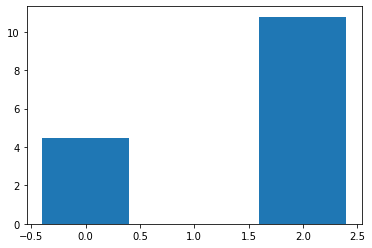

In [48]:
import matplotlib.pyplot as plt
plt.bar(df_comb.label, df_comb.top5_vs_median)  # want two overlapping histograms

(array([58., 42.,  0.,  0.,  0.,  0.,  0.,  0., 49., 51.]),
 array([ 2.9929078 ,  3.77218845,  4.5514691 ,  5.33074975,  6.1100304 ,
         6.88931104,  7.66859169,  8.44787234,  9.22715299, 10.00643364,
        10.78571429]),
 <a list of 10 Patch objects>)

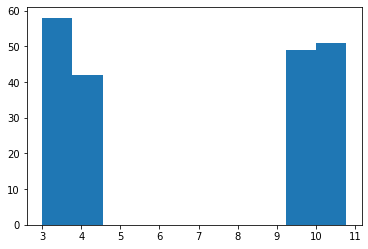

In [49]:
plt.hist(df_comb.top5_vs_median) # df_comb.label

# Tesla Decision Tree Classification with Scikit Learn

In [55]:
from sklearn.tree import DecisionTreeClassifier         # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split    # Import train_test_split function
from sklearn import metrics                             # Import scikit-learn metrics module for accuracy calculation


In [56]:
feature_cols = ['total','average','max_kwh','top5','top_decile','median','top5_vs_median']

X = df_comb[feature_cols] # Features
y = df_comb.label         # Target variable 


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1) # 60% training and 40% test


In [53]:
# Create Decision Tree classifer object
dtree_T = DecisionTreeClassifier(random_state=3, criterion='entropy',splitter='best', max_depth= 3,
                                 min_samples_split=2)          
dtree_T = dtree_T.fit(X_train,y_train)          # Train Decision Tree Classifer
y_pred = dtree_T.predict(X_test)            # Predict the response for test dataset

#clf = clf.fit(X,y)          # Train Decision Tree Classifer just for test set for now
# y_pred = clf.predict(X)

In [54]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 1.0


In [57]:
# All of the below implemented: but still 99% accurate with a test set of 80 (0.4 x (100 + 100))
# Hmmm. this was expected, given the clear demarcation
# Increased to samples of 100 each, and repeated with Train Test Split
# PHEV addition, as for Tesla
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

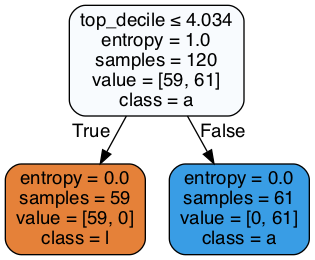

In [58]:
# Add graphics to understand which variables selected for Tree and parameter breaks!
dot_data = StringIO()
export_graphviz(dtree_T, out_file=dot_data, special_characters=True,filled=True, rounded=True,
                        feature_names= ['total','average','max_kwh','top5','top_decile','median','top5_vs_median'],  
                        class_names= 'label')
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
# This Tree has just a single branch, and accurately predicts Tesla if the median kwh exceeds 0.735 kwh

# PHEV Classification

In [59]:
df_BPHEV = pd.concat([df_base_mSU, df_mPHEV],ignore_index= True)
df_BPHEV.head() # These are non-EV with label of 0

,total,average,max_kwh,top5,top_decile,median,top5_vs_median,label
0,2996.152,1.371864,6.53,3.5110,2.944,0.96,3.657292,0
1,2733.540,1.251621,7.49,3.2600,2.620,0.90,3.622222,0
2,3095.430,1.417321,7.49,3.4600,2.940,1.09,3.174312,0
3,3063.558,1.402728,7.62,3.6500,2.940,0.96,3.802083,0
4,3101.662,1.420175,7.62,3.6401,2.880,1.02,3.568725,0


In [60]:
df_BPHEV.tail()   # These are PHEV with label of 1

,total,average,max_kwh,top5,top_decile,median,top5_vs_median,label
195,3049.192,1.396150,7.49,3.58,2.75,0.96,3.729167,1
196,3119.014,1.428120,7.49,3.58,2.94,1.09,3.284404,1
197,3010.414,1.378395,6.66,3.33,2.50,1.02,3.264706,1
198,3012.518,1.379358,7.49,3.46,2.69,0.96,3.604167,1
199,3070.144,1.405744,7.49,3.52,2.75,1.02,3.450980,1


In [61]:
feature_names = ['total','average','max_kwh','top5','top_decile','median','top5_vs_median']

Xphev = df_BPHEV[feature_names] # Features
yphev = df_BPHEV.label         # Target variable 

In [62]:
Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xphev, yphev, test_size=0.4, random_state=1) 
# 60% training and 40% test We now have 80 in the Test (40% of 200)

# Decision Tree Classifier for PHEV vs Summer

In [63]:
# Create Decision Tree classifer object for P = PHEV
dtree_P = DecisionTreeClassifier(random_state=3, criterion='entropy',splitter='best', max_depth= 4,
                                 min_samples_split=2)           
dtree_P = dtree_P.fit(Xp_train,yp_train)          # Train Decision Tree Classifer
yp_pred = dtree_P.predict(Xp_test)            # Predict the response for test dataset

In [64]:
# Model Accuracy, how often is the classifier correct for PHEV vs Baseline Summer?
print("PHEV Accuracy:",metrics.accuracy_score(yp_test, yp_pred))

PHEV Accuracy: 0.8125


In [65]:
# min_samples_split : int, float, optional (default=2) The minimum number of samples required to split an internal node:
# If int, then consider min_samples_split as the minimum number. If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the 
# minimum number of samples for each split.

In [66]:
# Yet another attempt, this time from Medium

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

# X InvocationException: GraphViz's executables not found Resolved by renstalling packages 
# conda install -c anaconda graphviz/ conda install -c anaconda pydot !!!

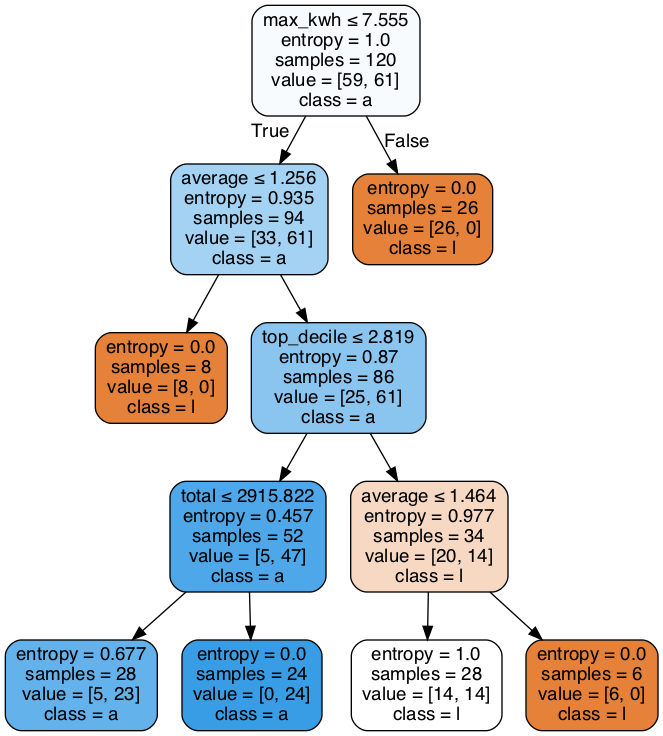

In [67]:
dot_data = StringIO()
export_graphviz(dtree_P, out_file=dot_data, special_characters=True,filled=True, rounded=True,
                        feature_names= ['total','average','max_kwh','top5','top_decile','median','top5_vs_median'],  
                        class_names= 'label')
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
# DWW Interpretation....CONFUSING!!! not intuitive , so reduced # of levels to 4 (as below).
# 1. if max_kwh > 7.555 then PHEV (Red Box) 28/28 of 61          
# 2. if max_kwh < 7.555 BUT (average < 1.269 AND max_kwh > 6.11), then PHEV (12/12 cases)
# DWW: equivalent to max_kwh between [6.11, 7.55] AND average < 1.269: so Max is large RELATIVE to average (sensible)
# 3. if max_kwh < 7.555 AND (average > 1.269 AND top5 > 3.55 AND max_kwh > 6.5) THEN PHEV ()
# So correctly classified for Train set is: 28 + 12 + 11 = 51 "True Positives"
# NB Darker boxes are more confident!! Relatively pure! 
# Very light is about 50/50 !! (see bottow row, third box: pale since 16/14 split is almost 50/50 !!)

In [68]:
len(['total','average','max_kwh','top5','top_decile','median','top5_vs_median'])

7

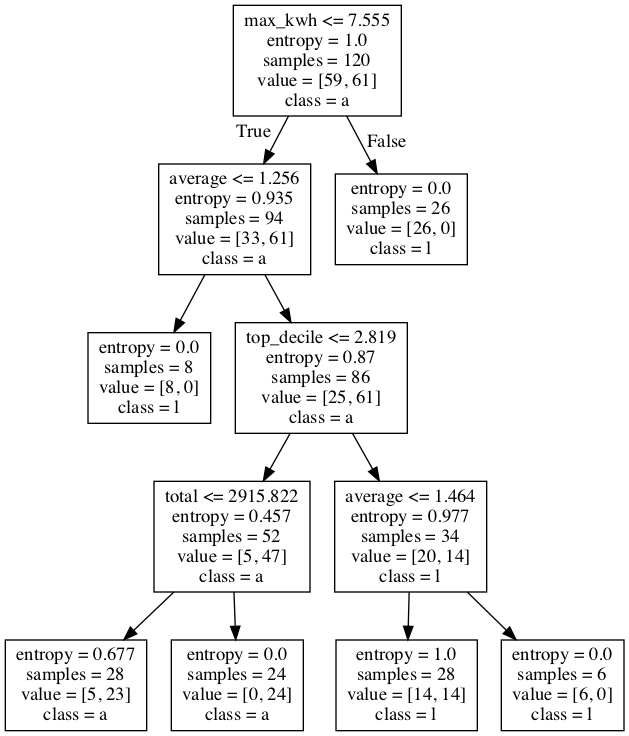

In [69]:
from sklearn import tree
from IPython.display import Image
import pydotplus
dt = tree.DecisionTreeClassifier(random_state=3, criterion='entropy',
splitter='best', max_depth= 4, min_samples_split=2)
 
clfP = dt.fit(Xp_train,yp_train)

# Create DOT data
dot_data = tree.export_graphviz(clfP, out_file= "resume.dot", 
                                feature_names= ['total','average','max_kwh','top5','top_decile','median','top5_vs_median'],  
                                class_names= 'label')

graph= pydotplus.graphviz.graph_from_dot_file("resume.dot") 
Image(graph.create_png())  # where label/Class =1 is for PHEV  : NB THIS TREE HAS NINE LEVELS !!!!! see max-depth

In [70]:
# where label/Class =1 is for PHEV  : NB THIS TREE HAD NINE LEVELS !!!!! see max-depth
# DWW interpretation:
# 1. if max_kwh > 7.555 then PHEV (28 cases of 60 PHEV)
# 2. if max_kwh < 7.555 BUT then PHEV

In [71]:
import numpy as np
# yp_pred # shows labels, not probabilities! how do we show probabilities?
probs = dtree_P.predict_proba(Xp_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# len(probs) = 80 for the Test set
probs.round(decimals= 2)



array([0.82, 0.  , 0.  , 0.82, 0.82, 1.  , 0.  , 0.  , 0.  , 0.82, 1.  ,
       0.5 , 0.  , 0.  , 0.82, 0.82, 1.  , 0.5 , 0.82, 0.  , 0.  , 0.5 ,
       0.5 , 0.  , 0.  , 0.5 , 0.5 , 0.  , 0.5 , 0.  , 0.  , 0.82, 0.5 ,
       1.  , 0.5 , 0.5 , 0.  , 0.  , 0.  , 0.82, 0.5 , 0.82, 1.  , 0.  ,
       0.  , 0.  , 0.82, 0.5 , 1.  , 1.  , 0.82, 0.5 , 0.5 , 0.82, 0.  ,
       0.5 , 0.82, 1.  , 1.  , 0.82, 1.  , 0.5 , 0.  , 0.  , 0.  , 0.  ,
       0.82, 0.5 , 0.  , 0.5 , 0.  , 0.  , 0.5 , 1.  , 1.  , 0.5 , 0.5 ,
       1.  , 0.  , 1.  ])

In [72]:
# Hmmm...the first 40 and the second 40 should be quite different but seem similar?
print(np.mean(probs[0:40]),np.mean(probs[40:80]))
# Different, but not VERY different

0.40982142857142856 0.53125


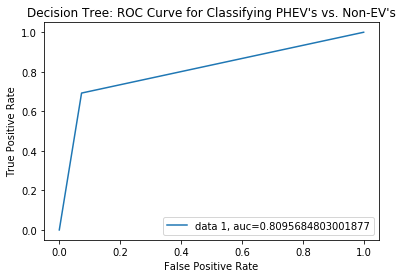

In [73]:
# AUC Curve....80% of PHEV's can be Identfied with only a 15% False-Positive Rate: then deteriorates markedly.
# The straight line with a kink suggests that just two "leafs" occur, with a high and a lower probability.
# This is for PHEV vs. Data sampled for the season: 'Summer' (SU)
# if Repeat for Fall would be more conformed, as this is the largest component (almost half - 14/30 weeks)
# could also match the dates exactly and compare fore this exact period!!
import matplotlib.pyplot as plt
fpr, tpr, _ = metrics.roc_curve(yp_test, yp_pred)       # NB Third argument is underscore_, prob may be needed??
auc = metrics.roc_auc_score(yp_test, yp_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Decision Tree: ROC Curve for Classifying PHEV's vs. Non-EV's")
plt.show()


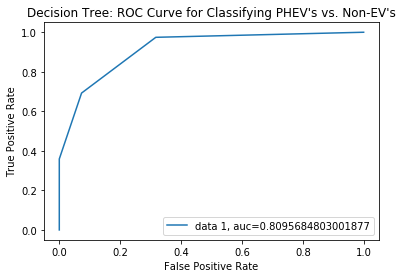

In [74]:
fpr_p, tpr_p, prob_p = metrics.roc_curve(yp_test, probs)   # Third argument should be probs, not Labels!!! Sarkar
auc = metrics.roc_auc_score(yp_test, yp_pred)        # But we get the same kinked curve as probs = 1.0 or 0.0
plt.plot(fpr_p,tpr_p,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Decision Tree: ROC Curve for Classifying PHEV's vs. Non-EV's")
plt.show()

In [75]:
for items in zip( tpr_p,fpr_p, prob_p):    # read this from the bottom!! 0.6 is a good threshold or .59
    print(items)        # .round(decimals= 2) AttributeError: 'tuple' object has no attribute 'round'
# third element is threshold class probability: even with 1 we still have 7% FP

(0.0, 0.0, 2.0)
(0.358974358974359, 0.0, 1.0)
(0.6923076923076923, 0.07317073170731707, 0.8214285714285714)
(0.9743589743589743, 0.3170731707317073, 0.5)
(1.0, 1.0, 0.0)


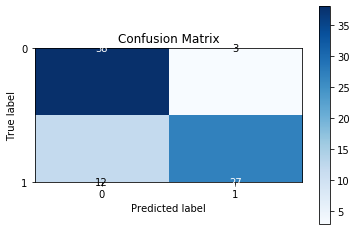

In [76]:
import scikitplot as skplt    # package installed as scikit-plot : CONFUSING!!
# use Seaborn!!
skplt.metrics.plot_confusion_matrix(yp_test, yp_pred, normalize=False)
plt.show()
# DWW Interpretation: 
# There were properly 39 PHEV's. We predicted 35 + 8 PHEV's, of which 35 were correct.
# So we found 35 of the actual 39.


In [78]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
labels= ['negative','positive']
print(classification_report(yp_test, yp_pred))
pd.DataFrame(confusion_matrix(yp_test,yp_pred),index=labels,columns= labels)

              precision    recall  f1-score   support

           0       0.76      0.93      0.84        41
           1       0.90      0.69      0.78        39

   micro avg       0.81      0.81      0.81        80
   macro avg       0.83      0.81      0.81        80
weighted avg       0.83      0.81      0.81        80



,negative,positive
negative,38,3
positive,12,27


# AUC varies greatly with each simulation: 
# DTree 0.83 then 0.9: Random Forest Worse than Tree: Logistic 0.73 then 0.57

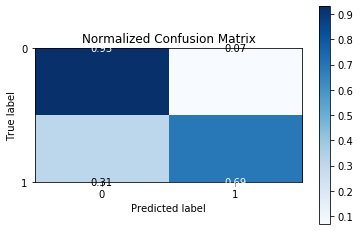

In [79]:
import scikitplot as skplt    # package installed as scikit-plot : CONFUSING!!
skplt.metrics.plot_confusion_matrix(yp_test, yp_pred, normalize=True)
# matplotlib.axes._subplots.AxesSubplot object at 0x7fe967d64490>
plt.show()


In [80]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

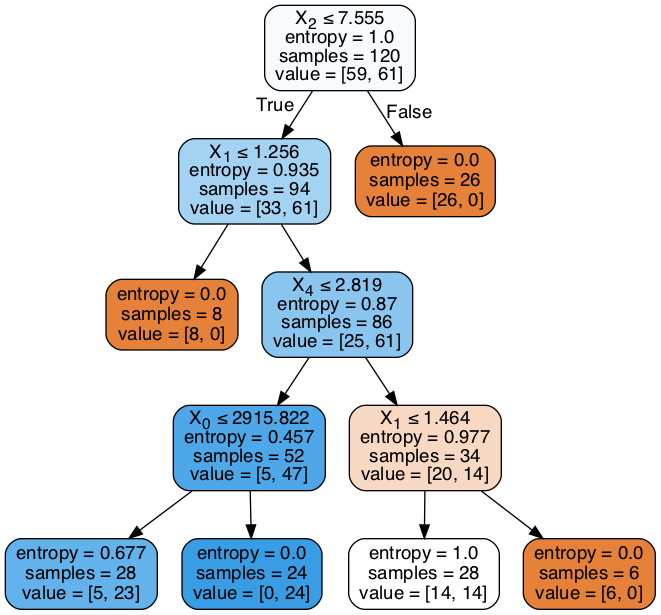

In [81]:

dot_data = StringIO()
export_graphviz(dtree_P, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# Logistic Regression

In [82]:
# If we had logistic regression as the classifier, then would the ROC curve would be more continuous???
from sklearn.linear_model import LogisticRegression

In [83]:
L_model = LogisticRegression(penalty='l2', C=0.1)                   # Logistic Regression
L_model = L_model.fit(Xp_train,yp_train)                       # Train Decision Tree Classifer
yp_pred_L = L_model.predict(Xp_test)                        # Predict the response for test dataset

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [84]:
# yp_pred # shows labels, not probabilities! how do we show probabilities?
probs_L = L_model.predict_proba(Xp_test)
# keep probabilities for the positive outcome only
probs_L = probs_L[:, 1]
probs_L
# Hmmm...this is for 30 observations BUT we do have probabilities!!!

array([0.52219439, 0.46144625, 0.49085426, 0.44596775, 0.45172363,
       0.48533009, 0.3992071 , 0.47358743, 0.48253655, 0.64299586,
       0.59515571, 0.49968359, 0.47849153, 0.50244398, 0.55007469,
       0.59231661, 0.57427998, 0.47144129, 0.59365867, 0.39721978,
       0.45956419, 0.49623317, 0.57760511, 0.52859793, 0.49201416,
       0.554847  , 0.45731416, 0.35306402, 0.47789644, 0.47214079,
       0.44039924, 0.61137086, 0.45085693, 0.47050183, 0.46765495,
       0.44818368, 0.59682399, 0.39265545, 0.39168428, 0.44560343,
       0.54896371, 0.53876433, 0.48881431, 0.50653383, 0.41734823,
       0.4469812 , 0.53245043, 0.45271227, 0.5716484 , 0.55862255,
       0.4069932 , 0.58919701, 0.45692914, 0.50210751, 0.39722695,
       0.45747466, 0.60977903, 0.47715997, 0.49015919, 0.44023121,
       0.5550491 , 0.59880208, 0.31236608, 0.41154058, 0.50506834,
       0.51963596, 0.5841032 , 0.45096373, 0.50490182, 0.58992177,
       0.39209347, 0.4610035 , 0.5858757 , 0.48681546, 0.59224

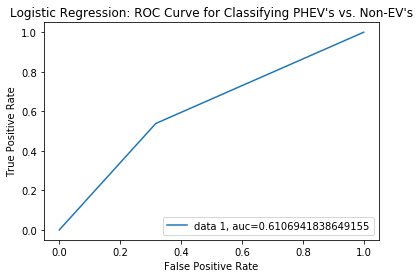

In [85]:
fpr, tpr, prob = metrics.roc_curve(yp_test,  yp_pred_L)  # NEW CODE
auc = metrics.roc_auc_score(yp_test, yp_pred_L)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Logistic Regression: ROC Curve for Classifying PHEV's vs. Non-EV's")
plt.show()
# Hmmm....AUC has gone down a lot, and still not continuous!!!

In [86]:
for items in zip(fpr, tpr, prob):      # sarkar ...read from the bottom??
    print(items)

(0.0, 0.0, 2)
(0.3170731707317073, 0.5384615384615384, 1)
(1.0, 1.0, 0)


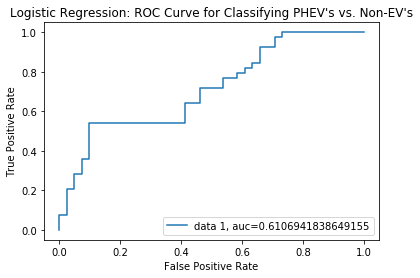

In [87]:
fpr, tpr, prob = metrics.roc_curve(yp_test,  probs_L)   # Third argument should be probs, not Labels!!! Sarkar
auc = metrics.roc_auc_score(yp_test, yp_pred_L)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Logistic Regression: ROC Curve for Classifying PHEV's vs. Non-EV's")
plt.show()
# Hmmm....AUC has gone down a lot, and still not continuous!!!

In [88]:
for items in zip(fpr, tpr, prob):    # read this from the bottom!! 0.6 is a good threshold or .59
    print(items)

(0.0, 0.0, 1.6429958631690669)
(0.0, 0.02564102564102564, 0.6429958631690669)
(0.0, 0.07692307692307693, 0.6097790307973897)
(0.024390243902439025, 0.07692307692307693, 0.5988020764853201)
(0.024390243902439025, 0.20512820512820512, 0.592240816592197)
(0.04878048780487805, 0.20512820512820512, 0.5899217704340856)
(0.04878048780487805, 0.28205128205128205, 0.5841032009792989)
(0.07317073170731707, 0.28205128205128205, 0.5776051079062517)
(0.07317073170731707, 0.358974358974359, 0.5702400594585695)
(0.0975609756097561, 0.358974358974359, 0.5600578254153684)
(0.0975609756097561, 0.5384615384615384, 0.5324504323952929)
(0.4146341463414634, 0.5384615384615384, 0.49085425925897064)
(0.4146341463414634, 0.6410256410256411, 0.48533008660294896)
(0.4634146341463415, 0.6410256410256411, 0.4784915316725263)
(0.4634146341463415, 0.717948717948718, 0.4752227624981288)
(0.5365853658536586, 0.717948717948718, 0.4714412905647003)
(0.5365853658536586, 0.7692307692307693, 0.46765494696062315)
(0.5853658

# Random Forest Classifier

In [89]:
# Try a RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier

# Limit max depth
forest = RandomForestClassifier(max_depth = 4, n_estimators=10)

forest.fit(Xp_train,yp_train)             # Train
yp_pred_F = forest.predict(Xp_test)      # Predict the response for test dataset

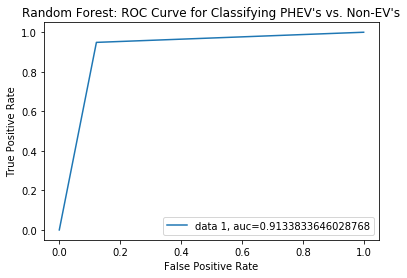

In [90]:
fpr, tpr, _ = metrics.roc_curve(yp_test,  yp_pred_F)        # Third argument should be probs, not Labels!!! Sarkar
auc = metrics.roc_auc_score(yp_test, yp_pred_F)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Random Forest: ROC Curve for Classifying PHEV's vs. Non-EV's")
plt.show()

In [91]:
probs_F = forest.predict_proba(Xp_test)
# keep probabilities for the positive outcome only
probs_F[0:5]         # [:1]
# Hmm...just want the first entries!? Extract via a list comprehension?
# type(probs_F) #= numpy.ndarray


array([[0.2797915 , 0.7202085 ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.24633163, 0.75366837],
       [0.16669626, 0.83330374]])

In [92]:
#.round(decimals= 2)

In [93]:
print([probs_F[i][0].round(decimals= 2) for i in range(len(probs_F))]) 

[0.28, 1.0, 1.0, 0.25, 0.17, 0.2, 0.97, 0.97, 0.97, 0.35, 0.21, 0.59, 0.97, 1.0, 0.28, 0.35, 0.1, 0.63, 0.17, 0.97, 0.85, 0.79, 0.76, 0.95, 1.0, 0.51, 0.52, 0.87, 0.4, 0.85, 0.85, 0.26, 0.52, 0.17, 0.47, 0.51, 0.25, 1.0, 0.97, 0.22, 0.43, 0.26, 0.26, 0.82, 0.79, 0.93, 0.19, 0.5, 0.21, 0.2, 0.36, 0.25, 0.4, 0.36, 0.85, 0.4, 0.16, 0.2, 0.1, 0.28, 0.17, 0.76, 1.0, 1.0, 1.0, 0.85, 0.27, 0.4, 1.0, 0.38, 0.85, 0.88, 0.3, 0.18, 0.17, 0.37, 0.56, 0.21, 1.0, 0.21]


In [94]:
# Extract single tree
estimator_limited = forest.estimators_[5]

In [95]:
import scikitplot as skplt
import matplotlib.pyplot as plt

# y_true =              # ground truth labels.                                                                              Here y_test
# y_probas =         # predicted probabilities generated by sklearn classifier.          Here y_pred ?
skplt.metrics.plot_roc_curve(y, y_pred)
plt.show()


/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


IndexError: too many indices for array

# Repeat for PHEV in Fall (F)

In [96]:
df_base_mF= df_metrics(dfF)  # metrics for F = Fall
df_base_mF
df_base_mF['label']= 0
df_base_mF

,total,average,max_kwh,top5,top_decile,median,top5_vs_median,label
0,2396.092,1.097112,6.21,2.6200,1.860,0.900,2.911111,0
1,2213.422,1.062613,4.80,2.4932,1.790,0.900,2.770222,0
2,2500.080,1.159054,5.25,2.5600,1.920,0.960,2.666667,0
3,2304.632,1.068443,5.70,2.5000,1.860,0.900,2.777778,0
4,2548.592,1.166938,5.25,2.5600,1.962,1.020,2.509804,0
5,2280.792,1.044319,5.50,2.3700,1.730,0.832,2.848558,0
6,2239.258,1.067330,5.25,2.5090,1.860,0.830,3.022892,0
7,2270.102,1.052435,6.78,2.5600,1.860,0.830,3.084337,0
8,2165.450,1.032150,5.31,2.6200,1.790,0.770,3.402597,0
9,2368.142,1.084314,5.25,2.5600,1.920,0.900,2.844444,0


In [97]:
df_BF_PHEV = pd.concat([df_base_mF, df_mPHEV],ignore_index= True)  # BF is Base Fall
df_BF_PHEV

,total,average,max_kwh,top5,top_decile,median,top5_vs_median,label
0,2396.092,1.097112,6.21,2.6200,1.8600,0.900,2.911111,0
1,2213.422,1.062613,4.80,2.4932,1.7900,0.900,2.770222,0
2,2500.080,1.159054,5.25,2.5600,1.9200,0.960,2.666667,0
3,2304.632,1.068443,5.70,2.5000,1.8600,0.900,2.777778,0
4,2548.592,1.166938,5.25,2.5600,1.9620,1.020,2.509804,0
5,2280.792,1.044319,5.50,2.3700,1.7300,0.832,2.848558,0
6,2239.258,1.067330,5.25,2.5090,1.8600,0.830,3.022892,0
7,2270.102,1.052435,6.78,2.5600,1.8600,0.830,3.084337,0
8,2165.450,1.032150,5.31,2.6200,1.7900,0.770,3.402597,0
9,2368.142,1.084314,5.25,2.5600,1.9200,0.900,2.844444,0


In [98]:
feature_cols = ['total','average','max_kwh','top5','top_decile','median','top5_vs_median']

Xphev_F = df_BF_PHEV[feature_cols] # Features
yphev_F = df_BF_PHEV.label         # Target variable 

In [99]:
Xp_train_F, Xp_test_F, yp_train_F, yp_test_F = train_test_split(Xphev_F, yphev_F, test_size=0.4, random_state=1) # 70% training and 30% test

In [100]:
#clf = clf.fit(X,y)          # Train Decision Tree Classifer just for test set for now
# y_pred = clf.predict(X)
dtree_T = DecisionTreeClassifier(max_depth= 4)          # Create Decision Tree classifer object
dtree_T = dtree_T.fit(X_train,y_train)          # Train Decision Tree Classifer
y_pred = dtree_T.predict(X_test)    

In [101]:
dtree_P_F = DecisionTreeClassifier()   
dtree_P_F = dtree_P_F.fit(Xp_train_F,yp_train_F)          # Train Decision Tree Classifer
yp_pred_P_F = dtree_P_F.predict(Xp_test_F)            # Predict the response for test dataset

In [102]:
# Model Accuracy, how often is the classifier correct for PHEV vs Baseline Fall?
# For PHEV vs Summer, misclassification occurred because levels are high in the Summer, as for PHEV's
# But vs. the Fall, the higher values of PHEV show up more,
print("PHEV Accuracy:",metrics.accuracy_score(yp_test_F, yp_pred_P_F))

PHEV Accuracy: 1.0


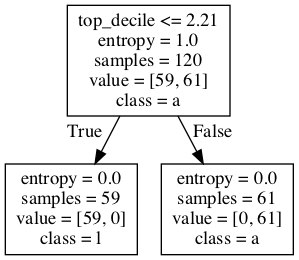

In [103]:
# Now Plot Tree to see if many levels!! (reduce to five levels, for example?)
from sklearn import tree
from IPython.display import Image
import pydotplus
dt = tree.DecisionTreeClassifier(random_state=3, criterion='entropy',
splitter='best', max_depth=None, min_samples_split=2)
 
clfPF = dt.fit(Xp_train_F,yp_train_F)

# Create DOT data
dot_data = tree.export_graphviz(clfPF, out_file= "resume.dot", 
                                feature_names= ['total','average','max_kwh','top5','top_decile','median','top5_vs_median'],  
                                class_names= 'label')

graph= pydotplus.graphviz.graph_from_dot_file("resume.dot") 
Image(graph.create_png())
# where label/Class =1 is for PHEV  
# NB THIS TREE HAS JUST one LEVEL
# if top_decile < 2.175 TRUE then Class=1 = PHEV !? THIS SEEMS BACKWARDS!!! CHECK DATA !!
# DATA is correct but graph seems misleading !!!
# top_decile > 2.175 for all 100 PHEV and < 2.175 for all 100 Fall observations
# NB Why 120 samples: this is  Train only !!

In [ ]:
# DWW Interpretation: 'top-decile' of 24 hours day is 2.4 hours, usually charging several hours at "Level 1" rate.


In [ ]:
Use the height and width to calculate the area
def calculate_area(row):
return row['height'] * row['width']
Use .apply to save the new column if we'd like
rectangles_df['area'] = rectangles_df.apply(calculate_area, axis=1)
rectangles_df

Use the height and width to calculate the area
def calculate_area(row):
return row['height'] * row['width']
Use .apply to save the new column if we'd like
rectangles_df['area'] = rectangles_df.apply(calculate_area, axis=1)
rectangles_df

# II. EXPLORATORY DATA ANALYSIS

In [ ]:
import matplotlib.pyplot as plt
weekly= dft.kwh.resample('W').sum()
monthly= 0.25 * dft.kwh.resample('M').sum()
plt.plot(weekly)
plt.plot(monthly)
plt.title('Weekly & Monthly Household Power Consumption in kwh')
plt.ylabel('kwh')
plt.show()        #

What is surprising about the above time series is that despite the family's addition of two energy-intensive children (including due to more laundry and cooking), and a small EV in 2018, replaced by a large EV in 2019, the highest weekly peaks occured not in the last year, but rather in 2012 and 2013. 
This could be weather related as hot summers and cold winters can materially increase the load.
Also the hourly peaks are most relevant, not the weekly totals and this matter needs to be investigated quite separately.

In [ ]:
plt.hist(dft.kwh, bins=30, density= True)
plt.title('Histogram of Hourly Power Consumption: August 2012 to Present')
plt.xlabel('Hourly Power Consumption in kwh')
plt.axvline(dft.kwh.mean(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(3.15, color='r', linestyle='dashed', linewidth=3)
plt.show()

In [ ]:
# A Python Dictionary of a selection of Load Factors and the respective number of age-equivalent years is provided here:
# age_acceleration_factors= {0.64:1, 0.70:2.65, 0.75:5.65, 0.80:11.67, 0.85:23.3, 0.90:38.9, 0.95:70.0}

In [ ]:
import seaborn as sns
# plt.figure() explore with shift-tab-tab with cursor positioned within parentheses
plt.figure(figsize= (15,10))    # this now fills the page so detail can be seen!!
sns.boxplot(x= dft.hour,y=dft.kwh)
plt.axhline(3.15, color='r', linestyle='dashed', linewidth=2)
plt.title('Boxplot of Hourly kwh Consumption by the Hour of the Day: August 2012 to Present')
plt.show()

In [ ]:
# seaborn.boxplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None, orient=None, color=None, 
#                palette=None, saturation=0.75, width=0.8, dodge=True, fliersize=5, linewidth=None, whis=1.5, notch=False, ax=None, **kwargs)¶

In [ ]:
plt.figure(figsize= (15,10)) # Have to record this before the boxplot is called, it seems!
sns.boxplot(dft.month, dft.kwh)
plt.axhline(3.15, color='r', linestyle='dashed', linewidth=2)
plt.title('Boxplot of Hourly Power Consumption by Month')

# NB the reason Months 2 & 3 have so many outliers at they include  half a month each of Tesla charging at 10 kwh
# Note also the interquartile ranges are exceeded in the months of June, July,and August: so 6 hours/day > 3.15 kwh
# March, April, May have the lowest loads die to the mild Spring temperatures (same for October in the Fall)

In [ ]:
plt.figure(figsize= (15,10)) 
sns.boxplot(dft.year, dft.kwh)
plt.axhline(3.15, color='r', linestyle='dashed', linewidth=2)
plt.title('Boxplot of Hourly Power Consumption by Year')
# The median consumption in the years 2012 & 2013 is NOT higher than 2014, so perhaps the high weekly 
# consumption level peaks in those years (see above) was due to weather conditions (eg a hot summer and a high A/C load).

# But in fact the years 2018 & 2019 are different
In these two years the upper quartile exceeds the 3.15 threshold, so it appears that a quarter of the time the threshold level for accelerating the ageing of the transformer is exceeded. However, this is only on an AVERAGE basis, and so is perhaps unduly conservative as the other [four] households served may have lower power consumption in that hour. Also in 2019 they have not yet acquired EV's.

In [ ]:
df_12= dft[dft.year== 2012]
df_12.head(3)

In [ ]:
plt.figure(figsize= (15,10)) 
# plt.axhline(3.15, color='r', linestyle='dashed', linewidth=2)
plt.plot(df_12.kwh)
plt.show()

In [ ]:
plt.figure(figsize= (15,10)) 
plt.axvline(3.15, color='r', linestyle='dashed', linewidth=2)
plt.hist(df_12.kwh, bins=20, density= False) # This shows frequencies so we can surmise > 100 hours exceeded threshold

In [ ]:
plt.figure(figsize= (15,10)) 
plt.axhline(3.15, color='r', linestyle='dashed', linewidth=2)
sns.boxplot(x= df_12.hour,y=df_12.kwh)
# Importantly this shows that from 1pm through 9pm (so nine hours) the interquartile range exceeds the 3.15 threshold
# So if household consumption is correlated (eg due to common very cold and hot temperatures), then premature ageing
# is possible (although these loads are linear) 

In [ ]:
monthly= df_12.kwh.resample('W').sum()

In [ ]:
plt.figure(figsize= (15,10)) 
plt.title('Histogram of Aggregate Monthly Power Consumption: 2012')
plt.ylabel('Power Consumption in kwh')
monthly.plot()

# A Small EV and a Level 1 "Trickle Charger" were Acquired in July, 2018¶
In the chart below, after July we see relatively little "white space" below the red horizontal line, suggesting that the trickle charger was active throughout much of the night.
We used to see daly minimums (during the night) of below 1 kwh, but after July the minimums commonly exceeded 1.75 kwh

In [ ]:
df_18= dft[dft.year== 2018]
plt.figure(figsize= (15,10)) 
df_18.kwh.plot()
plt.axhline(3.15, color='r', linestyle='dashed', linewidth=2)
plt.axhline(5.5, color='g', linestyle='dashed', linewidth=3)

plt.title("Hourly kwh Consumption in 2018: Level 1 Charger acquired in July")
plt.ylabel("kwh")
# plt.axvline(2018-07-01 00:00:00, color='y', linestyle='dashed', linewidth=5)# problem w datetime specification
# # plt.axvline(2018-07-01 , color='g', linestyle='dashed', linewidth=3)
plt.show()

In [ ]:
lows=  (df_18.kwh < 1.75)
sum(lows) # Hmmm this is > 75% of the hours so the chart is quite misleading being dominated by the ink for spikes.

In [ ]:
df_18.info() # hour and month are each strings (and categorical variables)
df_18.tail(3)

In [ ]:
df_18['kwhMA8C']= df_18.kwh.rolling(8,center= True).mean()

In [ ]:
plt.figure(figsize= (15,10))
plt.grid(True)
# plt.plot(df_18.kwh, label= 'kwh')
plt.plot(df_18.kwhMA8C, label= 'Centered 8-hour Moving Average')

In [ ]:
sum(df_18.kwh > 3.15) # so for the whole year 2018, of 8,760 hours just 466 exceeded the hourly threshold of 3.15 kwh

In [ ]:
# df_18.month.isin() # weird 'year' and month behave here like non-strings!!

In [ ]:
pre_L1= df_18[df_18.month.isin([1,2,3,4,5,6])]
post_L1= df_18[df_18.month.isin([7,8,9,10,11,12])]
pre_L1.head()

# One possible Signal for Classifying the new use of a Level 1 Charger is the number of times a certain hourly kwh threshold is exceeded
For example, in the first half of 2018 not once was an hourly consumption of more than 5.5 kwh recorded.
However, after the Level 1 charger was acquired in July, this threshold was exceeded 13 times.

In [ ]:
print(sum(pre_L1.kwh > 5.5))

In [ ]:
print(sum(post_L1.kwh > 5.5))

In [ ]:
# sum(df_18.kwh > 5.5) # this includes just one month and several days of EV ownership
# NEW CODE FOR ROLLING SIGNAL DAILY OR WEEKLY
peak_L1= df_18.kwh > 5.5
signal_L1= peak_L1.resample('M').sum() # Monthly is a more stable indicator: consistently more than 7x per week!
plt.figure(figsize= (15,10))
plt.title('Number of Hours per Week that 5.5 kwh L1 Signal Threshold is Exceeded')
plt.ylabel('Number of Hours')
# plt.axhline(7, color='r', linestyle='dashed', linewidth=2)
plt.plot(signal_L1)
# Exceeded regularly in Summer only due to AC load!

In [ ]:
peak_7year= dft.kwh > 5.5 # all years, rather than a single year
signal_7year= peak_7year.resample('M').sum() # Monthly is a more stable indicator: consistently more than 7x per week!
plt.figure(figsize= (15,10))
plt.title('Number of Hours per Month that 5.5kwh Signal Threshold is Exceeded')
plt.ylabel('Number of Hours')
# plt.axhline(7, color='r', linestyle='dashed', linewidth=2)
plt.plot(signal_7year)
# DWW could refine by specifying hours 6pm to 6am, as years 2102 and 2013 peaks due to an inefficient old AC unit.

In [ ]:
# NEW TROUGH CODE FOR ROLLING SIGNAL DAILY OR WEEKLY: Lows less frequent w Level 1 Charger
trough_L1= df_18.kwh < 0.75
trough_signal_L1= trough_L1.resample('M').sum() # Weekly is a more stable indicator?
plt.figure(figsize= (15,10))
plt.title('Number of Hours per Week that 0.75kwh Trough L1 Signal Threshold is Crossed')
plt.ylabel('Number of Hours')
# plt.axhline(7, color='r', linestyle='dashed', linewidth=2)
plt.plot(trough_signal_L1)
# DWW NB The low values at Left and right are misleading artefacts of the resample process!!! BEWARE!!

# Another possible Signal for Classifying the new use of a Level 1 Charger is derived from total monthly power consumption

The following analysis of (resampled) monthly data explores a potential Level 1 Charger Signal.
One idea is that with the acquisition of a Level 1 charger the monthly total kwh consumption should increase.

For example, charging for 1,000 miles driven each month would add about 333 kwh per month (since 1 kwh fuels c.3 miles).

A monthly_baseline is established, which is the average of the preceding four years (so 2014-2017 here).

This is of course just one "signal" or feature. It is desireable to posit a number of such features, and then to test which combination of them is most efffective in accurately classifying a large sample of EV's.

In [ ]:
df_18.kwh.resample('M').sum().plot()

In [ ]:
df_17= dft[dft.year== 2017]
df_17.kwh.resample('M').sum().plot()

In [ ]:
df_16= dft[dft.year== 2016]
df_16.kwh.resample('M').sum().plot()

In [ ]:
df_15= dft[dft.year== 2015]
df_15.kwh.resample('M').sum().plot()

In [ ]:
df_15.kwh.resample('M').sum().values

In [ ]:
df_14= dft[dft.year== 2014]
print(df_14.kwh.resample('M').sum().values)
df_14.kwh.resample('M').sum().plot()

In [ ]:
monthly_baseline= 0.25 * (df_14.kwh.resample('M').sum().values + df_15.kwh.resample('M').sum().values + 
                   df_16.kwh.resample('M').sum().values + df_17.kwh.resample('M').sum().values)

In [ ]:
plt.plot(monthly_baseline)
plt.plot(df_18.kwh.resample('M').sum().values)

In [ ]:
plt.axhline(0, color='r', linestyle='dashed', linewidth=2) # zero reference
plt.axhline(167, color='g', linestyle='dashed', linewidth=3)# 500 miles/month minimum is an extra 167 kwh/month
plt.plot(df_18.kwh.resample('M').sum().values - monthly_baseline)

# Repeating the above analysis but just for the 12 hours when the EV is likely to be at the residence (hours 0-5, 18-23 ): this yields a sharper contrast.

In [ ]:
dft.head()
# dft.hour.isin(['00','01','02','03','04','05','18','19','20','21','22','23']) #12 hours = half day, abbreviation H


In [ ]:
df_17H= dft[(dft.year== 2017) & (dft.hour.isin(['00','01','02','03','04','05','18','19','20','21','22','23']))]
df_17H.head(10)

In [ ]:
df_17H.kwh.resample('M').sum().plot()

In [ ]:
df_18H= dft[(dft.year== 2018) & (dft.hour.isin(['00','01','02','03','04','05','18','19','20','21','22','23']))]
df_18H.kwh.resample('M').sum().plot()

In [ ]:
df_18H= dft[(dft.year== 2018) & (dft.hour.isin(['00','01','02','03','04','05','18','19','20','21','22','23']))]
df_17H= dft[(dft.year== 2017) & (dft.hour.isin(['00','01','02','03','04','05','18','19','20','21','22','23']))]
df_16H= dft[(dft.year== 2016) & (dft.hour.isin(['00','01','02','03','04','05','18','19','20','21','22','23']))]
df_15H= dft[(dft.year== 2015) & (dft.hour.isin(['00','01','02','03','04','05','18','19','20','21','22','23']))]
df_14H= dft[(dft.year== 2014) & (dft.hour.isin(['00','01','02','03','04','05','18','19','20','21','22','23']))]
monthly_baseline_H= 0.25 * (df_14H.kwh.resample('M').sum().values + df_15H.kwh.resample('M').sum().values + 
                   df_16H.kwh.resample('M').sum().values + df_17H.kwh.resample('M').sum().values)

In [ ]:
plt.plot(monthly_baseline_H)
plt.plot(df_18H.kwh.resample('M').sum().values)

In [ ]:
# NEW CODE TO TRY  FOR MISSING CHART!
plt.axhline(0, color='r', linestyle='dashed', linewidth=2) # zero reference
plt.axhline(167, color='g', linestyle='dashed', linewidth=3)# 500 miles/month minimum is an extra 167 kwh/month
plt.plot(df_18.kwh.resample('M').sum().values - monthly_baseline_H)

# Hmmm Chart below does not look correct!! Monthly total increased by 600 kw/month !!  TOO MUCH!

In [ ]:
# BUT THIS VERSION (oddly not executed in the prior Notebook) DOES LOOK OK

plt.axhline(0, color='r', linestyle='dashed', linewidth=2)    # zero reference
plt.axhline(167, color='g', linestyle='dashed', linewidth=3)  # 500 miles/month minimum is an extra 167 kwh/month
plt.axvline(7, color='y', linestyle='dashed', linewidth=5)
plt.title('For the year 2018, Monthly Difference between Actual and the 4-Year baseline Consumption in kwh')
plt.xlabel('Month of the Year')
plt.ylabel('kwh')
plt.plot(df_18H.kwh.resample('M').sum().values - monthly_baseline_H)

# Successful Signal for Discerning the Acquisition of a Level 1 EV Charger
For the 12 hours (midnight to 6am, 6pm to midnight) that an EV is more likely to be at a residence,a monthly baseline is first established as the average of the preceding (trailing) 4 years, or 48 months.
This Baseline is then subtracted from the monthly values of the current year (for just the same 12 hours).
If the positive difference exceeds 167 kwh for three consecutive months, then the Residence is classified as owning a Level 1 EV charger. The 167 kwh/month threshold is predicated on an assumed 500 miles driven per month, and that 1 kwh fuels 3 miles of driving.

This approach can easily be generalised to the current months versus a four-year moving average.

# A Third possible Signal for Classifying the new use of a Level 1 Charger might derived from sequences of seven hours at night, or minimum threshold levels
One characteristic of a Level 1 charger (aka a "Trickle Charger) is that it is typically charging for a number of consecutive hours. For example, to provide for a 50-mile round trip would require about 17kwh, and at a charging rate of 1.9 kwh, that would take about nine consecutive hours. This might occur from 6pm to 3am, or from 9pm to 6am, for example. An approach that incorporates a seven-hour moving average might provide an indication of whether Level 1 EV charging is occuring.

# A Fourth possible Signal for Classifying the new use of a Level 1 Charger might be derived from a TOU-driven mini-spike
Where the EV charger is the customer of an electric utility that offers the option of a so-called "Time-Of-Use" (TOU) electricity tariff, EV chargers are incentivized to delay their charging until the onset of a designated "Off-Peak" period, which might start as early as 8pm or as late as midnight, and generally extends to 6am: the electricity tariff for the Off-Peak period is usually at a much lower price - even less than half the price for the preceding Peak Period. Most charging devices have timers, and the customers whohave chosen to subscribe to the TOU option therefore often set their timer to the onset of the Off-Peak period. Experience has shown that this tends to create a mini-peak. Incidentally, sometimes this option is offered to all of a utility's customers, while in other cases it may be offered exclusively to EV chargers who have signed up.

Since Corn Belt Energy does not currently offer a TOU Plan, this approach is not immediately relevant.

# An Ensemble Approach to Classification is often Superior

Four alternative signals have been outlined above that might be helpful in discerning whether a given household is an EV charger.

A statistical analysis can be performed to see which of the four Signals is superior. However,since the approaches are quite different, they may not be fully-correlated with one another. Accordingly, a mixture (ensemble approach) has often been found to be optimal.

This can be achieved in many ways, including by assigning appropriate weights to each of the different approaches.

Another way is to have a voting procedure. Suppose for example that three of the Signals are used, then each Classifier is assigned one vote, and the maority vote prevails.

# Risk Management Approach

There appears to be a significant assymettry in the cost of different outcomes (in formal terms, in the respective costs of Type I and Type II Classification errors). 

For example, suppose a household is initially classified by some judicious combination of the above-outlined Signals as having an EV charger, then the next steps may be:

(a) investigative (additional information gathering, for example), or 

(b) Promotional (making a highly attractive offer of some kind, for example to subscribe to a TOU plan, or to so-called Managed Charging).

Both of these steps are likely to be relatively inexpensive, and may represent wise precautionary investments with large associated benefits.

In contrast, consider the quite different cost of having missed one or more EV chargers served by the same local distribution transformer. Suppose that the transformer is repeatedly loaded during Peak Periods to 90% or more of its capacity, and its life is materially shortened as a result.Eventually a brown-out occurs, with two non-trivial costs. First, the transformer must be replaced, at a cost of the order of $7,500. Second, there may be repuational damage incurred, as all 5-7 households served by that transformer would have suffered from the consequences of the brown-out. Moreover, as such brown-out's become increasingly common in line with projected EV adoption levels, there could be delays in obtaining new transformers, and even in installing them, as qualified work crews become overburdened with such jobs. These costs could easily be one-hundred to one-thousand times higher.

Accordingly, it may be prudent to err on the side of caution and notionally classify a household as an EV charger even if the probability assigned by a chosen algorithm is less than 0.5. 

It would probably be sensible to accord quite different follow-up courses of action depending on whether the assigned probability was 0.3, 0.5, or 0.9. as the saying goes, "The devil is in the details".

# pane
df_18H.kwh.resample('M').sum().plot()
df_18H.kwh.resample('M').sum().plot()
df_18H.kwh.resample('M').sum().plot()
df_18H.kwh.resample('M').sum().plot()
df_18H.kwh.resample('M').sum().plot()

# A Small EV and a Level 1 "Trickle Charger" were Acquired in July, 2018
After July we see relatively little "white space" below the red horizontal line, suggesting that the trickle charger was active throughout much of the night.

In [ ]:
df_19= dft[dft.year== 2019]
plt.figure(figsize= (15,10))
df_19.kwh.plot()
plt.title('Hourly kwh Consumption: Level 2 Charger Acquired February 11th, 2019')
plt.ylabel('kwh')
plt.axhline(3.15, color='r', linestyle='dashed', linewidth=2)
plt.axhline(7, color='g', linestyle='dashed', linewidth=2)
plt.show()

# A Large (Tesla) EV and a Level 2 "Fast Charger" were Acquired in February, 2019
In mid-February and beyond we see 7 kwh of consumption frequently, while before even with the EV with the smaller battery it had been comparatively rare.

In [ ]:
sum(df_19.kwh > 7) # this includes just one month and several days of EV ownership
# NEW CODE FOR ROLLING SIGNAL DAILY OR WEEKLY
peak= df_19.kwh > 7
signal= peak.resample('W').sum() # Weekly is a more stable indicator: consistently more than 7x per week!
plt.figure(figsize= (15,10))
plt.title('Number of Times per Week that 7 kwh Signal Threshold is Exceeded')
plt.ylabel('Number of Times')
# plt.axhline(7, color='r', linestyle='dashed', linewidth=2)
plt.plot(signal)

In [ ]:
sum(df_18.kwh > 7)  # for the year, just a single occurrence

In [ ]:
sum(df_17.kwh > 7)  # for the year,not a single occurrence

In [ ]:
sum(df_16.kwh > 7)  # for the year, not a single occurrence
# Actually a number of occurences in July, 2012 when AC was old and inefficent

# Establishing a Baseline for Power Consumption using OLS Regression
The approach is to use 2017 as a baseline year for purposes of comparison.
The year 2018 is unsuitable as the numbers were materially higher in the second half of the year due to the small EV acquisition.

In [ ]:
# NEW: the following analysis takes the one-month, six day period of Tesla ownership and compares it to
# a baseline of the the same period for the preceding four years
# Can now be updated through mid July from Jeff Hevrin hopefully (uodate from Corn Belt metering data)

In [ ]:
k_19 = dft['2019-02-12':'2019-03-18']

In [ ]:
plt.plot(k_19.kwh) 

In [ ]:
plt.plot(k_19.kwh.resample('D').mean())

In [ ]:
k_19 = dft['2019-02-12':'2019-03-18'].kwh.reset_index()

In [ ]:
k_18 = dft['2018-02-12':'2018-03-18'].kwh.reset_index()
k_18[0:10]

In [ ]:
k_17 = dft['2017-02-12':'2017-03-18'].kwh.reset_index()


In [ ]:
k_16 = dft['2016-02-12':'2016-03-18'].kwh.reset_index()

In [ ]:
two_years= pd.merge(k_16, k_17, left_index= True, right_index= True)

In [ ]:
two_years.head()
two_years.columns= ['date_16','kwh_16','date_17','kwh_17']
two_years.head()

In [ ]:
three_years= pd.merge(two_years,k_18, left_index= True, right_index= True)

In [ ]:
three_years.head()
three_years.rename(columns= {'kwh_18':'kwh'})
three_years.head()

In [ ]:
four_years= pd.merge(three_years,k_19, left_index= True, right_index= True)
four_years.head()

In [ ]:
four_years.columns= ['date_16','kwh_16','date_17','kwh_17', 'date_18','kwh_18','date_19','kwh_19']
four_years.head()

In [ ]:
plt.plot(four_years.kwh_16)
plt.plot(four_years.kwh_19)


In [ ]:
four_years['baseline']= (four_years.kwh_16 + four_years.kwh_17 + four_years.kwh_18)/3
four_years= four_years.drop(['date_16','date_17','date_18'], axis= 1)
four_years.head()

In [ ]:
four_years['increment']= (four_years.kwh_19 - four_years.baseline)
four_years.head()

In [ ]:
plt.plot(four_years.baseline)
plt.plot(four_years.increment)
plt.show()

In [ ]:
four_years['hour']= four_years.date_19.dt.hour
four_years['weekday']= four_years.date_19.dt.weekday_name  # weekday to exlore if weekend charging during the day
# dft['weekday']= dft.date.dt.weekday_name
four_years.head(20)

In [ ]:
plt.hist(four_years.increment, bins=24, density= True)
plt.title('Histogram of Hourly Difference from Baseline')
plt.xlabel('Difference in kwh')
# NB Symmetric Distribution centered around zero is likely just random.
# We should therefore look at the most common hours for when the difference (aka 'increment') is more than 2.

In [ ]:
big_difference= four_years[four_years.increment > 2]
big_difference.head()

In [ ]:
plt.hist(big_difference.increment, bins=24, density= True)
plt.title('Histogram of Hourly Difference from Baseline when > 2')
plt.xlabel('Difference in kwh')

In [ ]:
gh= big_difference.groupby('hour')

In [ ]:
gh.mean()
print(gh.increment.mean())
# VERY INTERESTING THAT NO COUNTS FOR HOURS 2,3,4,5!!! CHARGING PRESUMABLY COMPLETED BY THEN??
# possibly bi-modal: hours 0 & 1 are highest, hours 6pm & 10pm are the next most common.
# matplotlib.pyplot.bar(x, height, width=0.8, bottom=None, *, align='center', data=None, **kwargs)[source]
plt.bar(gh.increment.mean(), height= 10)
#plt.plot(gh.increment.mean())
# DWW look at .sum() to give total additional 
# FAILED BAR PLOT ATTEMPT!!!


In [ ]:
gw= big_difference.groupby('weekday')
print(gw.increment.mean())
plt.plot(gw.increment.mean())  # make days properly continuous by making 'weekday' an ordered categorical variable !?
# The observed differences could just be random: no evidence of high Weekend charging: Sunday is the lowest day.

In [ ]:
g= four_years.groupby('hour')

In [ ]:
g.baseline.mean()
plt.plot(g.baseline.mean())
plt.plot(g.increment.mean())
plt.plot( g.baseline.mean() + g.increment.mean())

plt.show()
# DWW MUCH BETTER TO DO THIS AS A STACKED BAR CHART????

In [ ]:
print(g.baseline.mean())
print(g.increment.mean())

In [ ]:
# LOGARITHMIC EXPLORATIONS !!
# introduce logarithmic version!
import numpy as np 
df_17= dft[dft.year== 2017]
log= np.log(df_17.kwh)     # take log to base Ten (with e we have negative values!!)
log[0:10]

In [ ]:
# Dividing by zero error message received.
# "The proper solution here is to add some small epsilon to the argument of log function. What worked for me was

# epsilon = 1e-5    

# def cost(X, y, theta):
    m = X.shape[0]
    yp = expit(X @ theta)
    cost = - np.average(y * np.log(yp + epsilon) + (1 - y) * np.log(1 - yp + epsilon))
    return cost

In [ ]:
epsilon = 1e-5  
df_17['ln_kwh']= np.log(df_17.kwh + epsilon)
df_17.info()
df_17.head()

In [ ]:
# TEMPORAL MODEL ONLY: 2017
# This version updated by dropping the 'year' variable as redundant (as for 2017 only)
import statsmodels.api as sm
from statsmodels.formula.api import ols
m_ln= ols(formula= 'ln_kwh ~ hour + weekday + month', data= df_17).fit()  # .fit() already done (chained)




In [ ]:
print(m_ln.summary())  # Hmmm...R2 has droped from 18% to just 6.5% !!??
# this seems to be a much worse model and was examined only because of possible negative values with a non-log model
# But to simulate Accelerated Aging we are only interested in the other end of the distribution, 
# namely the very high values.
# CONCLUSION: Better to stay with the non-log formulation for now?(although variance would increase for higher values?)

# OLS Regression analysis for 2017


In [ ]:
# TEMPORAL MODEL ONLY: 2017
# This version updated by dropping the 'year' variable as redundant (as for 2017 only)
import statsmodels.api as sm
from statsmodels.formula.api import ols
m= ols(formula= 'kwh ~ hour + weekday + month', data= df_17).fit()  # .fit() already done (chained)

print(m.summary())

In [ ]:
# In Sample Prediction
kwh_pred= m.predict(df_17)
kwh_pred[0:24]
error= kwh_pred - df_17.kwh
error[0:10]
sum_of_squares= sum(error**2)
sum_of_squares
len(kwh_pred)
variance= (sum_of_squares/len(kwh_pred))
sigma= variance **0.5
sigma # for 2017 sigma = 0.72


In [ ]:
# IN SAMPLE PREDICTION WITH ERROR TERM SIMULATED
kwh_pred_w_epsilon= kwh_pred + sigma*np.random.normal(size= len(kwh_pred))
kwh_pred_w_epsilon[0:10]
# WHOOPS...we have negative hours! eg -1.36 in hour #2: therefore estimate ln kwh ?? (now negatives precluded!!)
# Properly should do a test for heteroskedacity??

In [ ]:
# Logarithmic model!?   TEMPORAL MODEL ONLY: 2017

from statsmodels.formula.api import ols
m= ols(formula= 'kwh ~ hour + weekday + month', data= df_17).fit()  # .fit() already done (chained)

print(m.summary())

In [ ]:
from datetime import datetime
import pandas as pd
f_date= pd.date_range(start= '1/1/2020', end= '12/31/2020', freq= 'H')  # f prefix for future dates: datetime object
dfF= pd.DataFrame(f_date, columns= ['f_date']) # creates df and names the column

dfF['hour']= dfF.f_date.dt.hour
dfF['weekday']= dfF.f_date.dt.weekday_name
dfF['month']= dfF.f_date.dt.month
dfF['year']= dfF.f_date.dt.year

dfF['hour']= dfF['hour'].astype('category')
dfF['weekday']= dfF['weekday'].astype('category')
dfF['month']= dfF['month'].astype('category')
dfF['year']= dfF['year'].astype('category')
dfF.head()

In [ ]:
# kwh_pred= m.predict(dfF) # data= dfF  need to add an error term, normally distributed
# + sig*random.normal(size= len(f_date))  # where sig is standard deviation of error term
import numpy as np 
epsilon= np.random.normal(size= len(f_date)) # need to import !!
epsilon[0:6]

In [ ]:
df_16= dft[dft.year== 2016]

In [ ]:
#  TEMPORAL MODEL ONLY: 2016
# Again, the redundant 'year' variable is dropped.
import statsmodels.api as sm
from statsmodels.formula.api import ols
m2= ols(formula= 'kwh ~ hour + weekday + month', data= df_16).fit()  # .fit() already done (chained)

print(m2.summary())

In [ ]:
import pandas as pd

In [ ]:
# Adding the Temperature variable
temps= pd.read_csv('chicago_hourly_temperatures.csv', usecols= [0,17])
temps.info()     # Note that the 'datetime variable is in fact just a string, and NOT a datetime object!!!
temps.head(3)

In [ ]:
import datetime as dt
temps['date']= pd.to_datetime(temps.datetime)
# raw_data['Mycol'] =  pd.to_datetime(raw_data['Mycol'], format='%d%b%Y:%H:%M:%S.%f')

In [ ]:
temps.info() # so the conversion was correctly parsed, but the hours appear to be Universal, namely Greenwich (+6)
# this is a problem as it does not match the hour in Chicago for the kwh usage !!!

In [ ]:
temps['C_date'] = temps.date - dt.timedelta(hours=6) # where 'C_date' is Chicago time.
temps.head(12)

In [ ]:
temps['hour']= temps.C_date.dt.hour
temps['month']= temps.C_date.dt.month
temps['year']= temps.C_date.dt.year
temps['F']= 1.8*(temps['Chicago'] - 273.15) + 32
temps.set_index(temps['C_date'], inplace= True)
temps.info()


In [ ]:
temps.head(12)

In [ ]:
temps= temps.drop(['datetime','Chicago','date'], axis=1)
temps['F_sqr']= temps.F**2
temps['F_cbd']= temps.F**3
temps['F_frth']= temps.F**4
temps.head(3)

In [ ]:
temps_17= temps[temps.year== 2017]

In [ ]:
temps_17.head(3)

In [ ]:
comb_17 = pd.merge(df_17, temps_17, left_index= True, right_index= True) # 'left_on= date, right_on= date)

In [ ]:
comb_17.head(3)

In [ ]:
comb_17.hour_y = comb_17.hour_y.astype('category', ordered= True)
comb_17.month_x= comb_17.month_x.astype('category', ordered= True)
comb_17.head(24)

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
m_F= ols(formula= 'kwh ~ hour_y + weekday + month_x + F + F_sqr + F_cbd + F_frth', data= comb_17).fit() 
# .fit() already done (chained)

print(m_F.summary())

# Hmmm 

In [ ]:
2**3

In [ ]:
comb_17.info()

In [ ]:
# Repeat after dropping month variable, seeing if temperature variable F is sufficient on its own
m_F_wo_month= ols(formula= 'kwh ~ hour_y + weekday + F + F_sqr + F_cbd + F_frth', data= comb_17).fit() 
# .fit() already done (chained)

print(m_F_wo_month.summary())

In [ ]:
g= temps.groupby('hour')

In [ ]:
F= 1.8*(g.mean()- 273.15) + 32
print(round(F, 1))

In [ ]:
pd.read_csv('chicago_hourly_temperatures.csv', usecols= [0,17])


In [ ]:
temps.head()

In [ ]:
comb= pd.merge()

# OLS.predict(X)
from datetime import datetime
dft['weekday']= dft.date.dt.weekday_name
dft['month']= dft.date.dt.month
dft['year']= dft.date.dt.year
dft.set_index(dft['date'], inplace= True)
dft= dft.drop(['day','date'], axis=1)
dft['hour']= dft['hour'].astype('category')
dft['weekday']= dft['weekday'].astype('category')
dft['month']= dft['month'].astype('category')
dft['year']= dft['year'].astype('category')
dft.info()
dft.head()

In [ ]:
from datetime import datetime
f_date= pd.date_range(start= '1/1/2020', end= '12/31/2020', freq= 'H')  # f prefix for future dates: datetime object
dfF= pd.DataFrame(f_dates, columns= ['f_date']) # creates df and names the column
dfF['hour']= dfF.dates.dt.month
dfF['weekday']= dfF.dates.dt.weekday_name
dfF['month']= dfF.dates.dt.month
dfF['year']= dfF.dates.dt.year
# dft.set_index(dft['date'], inplace= True)
# dft= dft.drop(['day','date'], axis=1)
dfF['hour']= dfF['hour'].astype('category')
dfF['weekday']= dfF['weekday'].astype('category')
dfF['month']= dfF['month'].astype('category')
dfF['year']= dfF['year'].astype('category')
dfF.info()
dfF.head()

In [ ]:
from datetime import datetime
dft['weekday']= dft.date.dt.weekday_name
dft['month']= dft.date.dt.month
dft['year']= dft.date.dt.year
dft.set_index(dft['date'], inplace= True)
dft= dft.drop(['day','date'], axis=1)
dft['hour']= dft['hour'].astype('category')
dft['weekday']= dft['weekday'].astype('category')
dft['month']= dft['month'].astype('category')
dft['year']= dft['year'].astype('category')
dft.info()
dft.head()

In [ ]:
from datetime import datetime
import pandas as pd
f_date= pd.date_range(start= '1/1/2020', end= '12/31/2020', freq= 'H')  # f prefix for future dates: datetime object
dfF= pd.DataFrame(f_date, columns= ['f_date']) # creates df and names the column

dfF['hour']= dfF.f_date.dt.hour
dfF['weekday']= dfF.f_date.dt.weekday_name
dfF['month']= dfF.f_date.dt.month
dfF['year']= dfF.f_date.dt.year

dfF['hour']= dfF['hour'].astype('category')
dfF['weekday']= dfF['weekday'].astype('category')
dfF['month']= dfF['month'].astype('category')
dfF['year']= dfF['year'].astype('category')
dfF.head()


In [ ]:
dfF.info()

In [ ]:
# Hmm for the purely temporal model volatility is underestimated greatly

In [ ]:
groupby hour and month mean 

In [ ]:
40000000/(42000 * 0.6)

 # OLD CODE BELOW TO BE EXCISED